In [1]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats


def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

In [5]:
class struct: pass

class struct: pass

opts = struct()
opts.rootdir = '/n/coxfs01/2p-data'
opts.animalid = 'JC085'
opts.session = '20190624'
opts.acquisition = 'FOV1_zoom4p0x'
opts.traceid = 'traces001'
opts.combined_run = 'scenes_combined'

response_type = 'df'
filter_crit = 'zscore'
filter_thresh = 1

traceid = '%s_s2p'%(opts.traceid)
#% Set up paths:    
acquisition_dir = os.path.join(opts.rootdir, opts.animalid, opts.session, opts.acquisition)
traceid_dir = os.path.join(acquisition_dir, opts.combined_run,'traces',traceid)

run_dir = traceid_dir.split('/traces')[0]
trace_arrays_dir = os.path.join(traceid_dir,'files')
paradigm_dir = os.path.join(acquisition_dir, opts.combined_run, 'paradigm')


responses_dir = os.path.join(acquisition_dir, opts.combined_run,'filtered_responses',traceid)

fig_out_dir = os.path.join(responses_dir,'figures')
if not os.path.exists(fig_out_dir):
    os.makedirs(fig_out_dir)
    


if 'norm' in response_type:
    i1 = findOccurrences(response_type,'_')[-1]
    fetch_data = response_type[i1+1:]
else:
    fetch_data = response_type

#get file with trial-by-trial responses
responses_dir = os.path.join(acquisition_dir, opts.combined_run,'responses',traceid)
data_array_dir = os.path.join(responses_dir, 'data_arrays')

resp_array_fn = 'trial_response_array.hdf5'
resp_array_filepath = os.path.join(data_array_dir, resp_array_fn)
resp_grp = h5py.File(resp_array_filepath, 'r')

if 's2p_cell_rois' in resp_grp.attrs.keys():
    cell_rois = resp_grp.attrs['s2p_cell_rois']
else:
    cell_rois = np.arange(nrois)

curr_slice = 'Slice01'#hard,coding for now

#unpack
response_matrix = np.array(resp_grp['/'.join([curr_slice, 'responses' ,fetch_data])])


filter_crit_matrix_trials = np.array(resp_grp['/'.join([curr_slice, 'responses' ,filter_crit])])

#considering only cell rois
response_matrix = response_matrix[:,:,cell_rois]
ntrials,nconfigs,nrois = response_matrix.shape
filter_crit_matrix_trials = filter_crit_matrix_trials[:,:,cell_rois]

resp_grp.close()

#avg over trials
filter_crit_matrix_mean = np.squeeze(np.mean(filter_crit_matrix_trials,0))

#consider a config active if at least one of theversion of an image evoked a response above threshol
thresh = filter_thresh
thresh_matrix = filter_crit_matrix_mean>thresh
filter_matrix = np.ones((thresh_matrix.shape))*np.nan
active_rois_per_config = np.nansum(thresh_matrix,1)
for ridx in range(nrois):
    for idx in range(0,thresh_matrix.shape[0],3):
            if np.sum(thresh_matrix[idx:idx+3,ridx])>0:
                filter_matrix[idx:idx+3,ridx] = 1

/n/coxfs01/cechavarria/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater


In [10]:
cell_rois[132]

194

In [6]:
response_matrix[:,:,132]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [100]:
#load trial info
stimconfig_fn = 'trial_conditions.hdf5'
stimconfig_filepath = os.path.join(paradigm_dir, 'files', stimconfig_fn)
config_grp = h5py.File(stimconfig_filepath, 'r')

trial_config = np.array(config_grp['trial_config'])
trial_cond = np.array(config_grp['trial_cond'])
trial_img = np.array(config_grp['trial_img'])

config_grp.close()


#for each roi, first average across trials per config, then normalize across configs
#-should result in higher values, also noticed bigger differences in values

nconfigs = len(np.unique(trial_config))
print('ROIs:%i'%(nrois))
print('Trials:%i'%(ntrials))

config_cond = np.empty((nconfigs,))
config_img = np.empty((nconfigs,))


for cfg_idx in np.unique(trial_config):
    tidx = np.where(trial_config == cfg_idx)[0]
    config_cond[int(cfg_idx)] = trial_cond[tidx][0]
    config_img[int(cfg_idx)] = trial_img[tidx][0]

mean_response_matrix = np.mean(response_matrix,0)
if 'norm' in response_type:
    norm_response_array = np.empty((nconfigs,nrois))

    for ridx in range(nrois):
        norm_response_array[:,ridx] = mean_response_matrix[:,ridx]/np.nanmax(mean_response_matrix[:,ridx])
    mean_response_matrix = norm_response_array
    
filt_response_array = mean_response_matrix*filter_matrix


#figure out some activity details
active_cell_idx = np.nansum(filter_matrix,0)>0
num_active_rois = np.nansum(np.nansum(filter_matrix,0)>0)
frac_active_rois = num_active_rois/float(len(cell_rois))
print('# active rois = %i'%(num_active_rois))
print('frac active rois = %.04f'%(frac_active_rois))


resp_diff = np.zeros(filt_response_array.shape)
mod_idx = np.zeros(filt_response_array.shape)
for ridx in range(nrois): 
    for cond_idx in range(0,nconfigs,3):
        if filter_matrix[cond_idx,ridx]:
            #tex - sf
            resp_diff[cond_idx,ridx] = filt_response_array[cond_idx+2,ridx] - filt_response_array[cond_idx+1,ridx]
            mod_idx[cond_idx,ridx] = np.true_divide(filt_response_array[cond_idx+2,ridx] - filt_response_array[cond_idx+1,ridx],\
                                                    filt_response_array[cond_idx+2,ridx] + filt_response_array[cond_idx+1,ridx])
            #orig - sf
            resp_diff[cond_idx+1,ridx] = filt_response_array[cond_idx,ridx] - filt_response_array[cond_idx+1,ridx]
            mod_idx[cond_idx+1,ridx] = np.true_divide(filt_response_array[cond_idx,ridx] - filt_response_array[cond_idx+1,ridx],\
                                                    filt_response_array[cond_idx,ridx] + filt_response_array[cond_idx+1,ridx])
            #orig - tex
            resp_diff[cond_idx+2,ridx] = filt_response_array[cond_idx,ridx] - filt_response_array[cond_idx+2,ridx]
            mod_idx[cond_idx+2,ridx] = np.true_divide(filt_response_array[cond_idx,ridx] - filt_response_array[cond_idx+2,ridx],\
                                                    filt_response_array[cond_idx,ridx] + filt_response_array[cond_idx+2,ridx])
        else:
            resp_diff[cond_idx:cond_idx+3,ridx] = np.nan
            mod_idx[cond_idx:cond_idx+3,ridx] = np.nan

img_response_mean = np.nanmean(filt_response_array,1)
img_response_se = np.true_divide(np.nanstd(filt_response_array,1),np.sqrt(active_rois_per_config))

ROIs:135
Trials:25
# active rois = 45
frac active rois = 0.3333


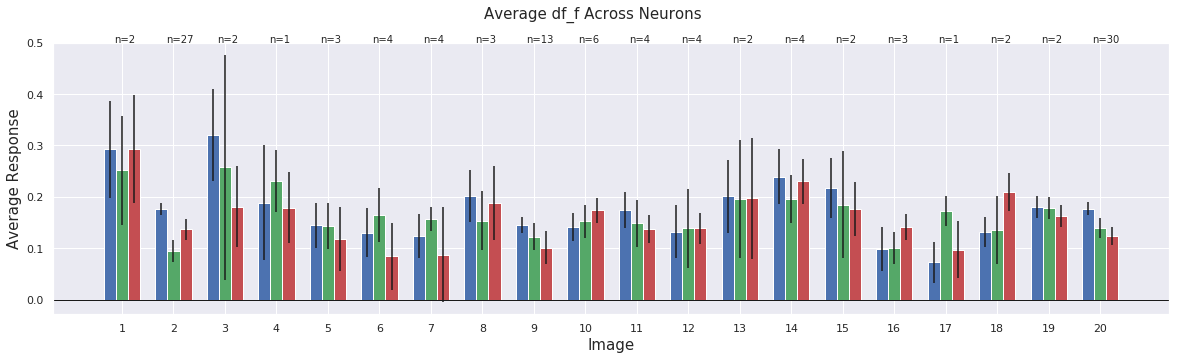

In [101]:
bar_loc = np.zeros((img_response_mean.size))
width = 0.4         # the width of the bars
gap = .5
xloc = 1
count = 0
for i in range(len(np.unique(trial_img))):
    for j in range(len(np.unique(trial_cond))):
        bar_loc[count] = xloc
        xloc = xloc + width
        count = count+1
    xloc = xloc + gap


fig = plt.figure(figsize=(20,5))
plt.bar(bar_loc[0:len(bar_loc):3],img_response_mean[0:len(bar_loc):3],width,color = 'b',yerr = img_response_se[0:len(bar_loc):3])
plt.bar(bar_loc[1:len(bar_loc):3],img_response_mean[1:len(bar_loc):3],width,color = 'g',yerr = img_response_se[1:len(bar_loc):3])
plt.bar(bar_loc[2:len(bar_loc):3],img_response_mean[2:len(bar_loc):3],width,color = 'r',yerr = img_response_se[2:len(bar_loc):3])

axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')

xtick_loc = bar_loc[1:len(bar_loc):3]
xtick_label = np.unique(trial_img+1).astype('int')

plt.xticks(xtick_loc,xtick_label.tolist())
plt.xlabel('Image',fontsize = 15)
plt.ylabel('Average Response',fontsize = 15)
plt.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)

count = 0
for idx in bar_loc[1:len(bar_loc):3]:
    plt.text(idx-.25, ymax, 'n=%i' % active_rois_per_config[count], fontsize=10)
    count = count +3
    
fig_fn = 'avg_across_neurons_%s_thresh_%s_%i.png'%(response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)

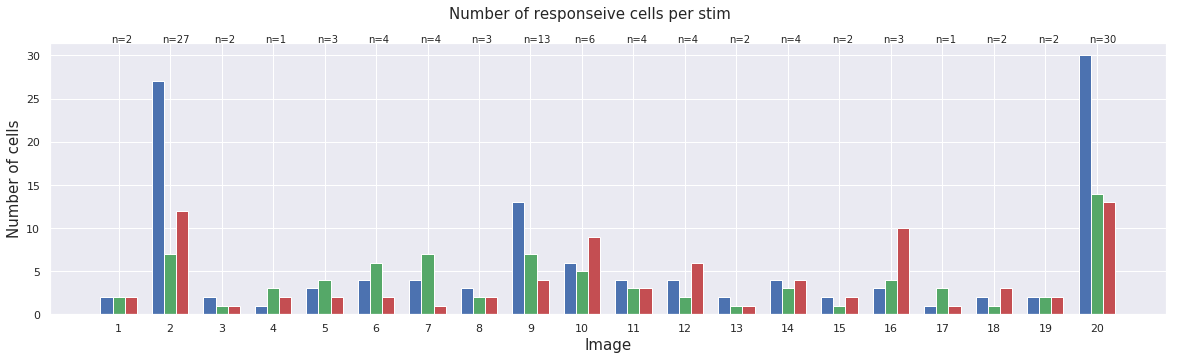

In [102]:
bar_loc = np.zeros((img_response_mean.size))
width = 0.4         # the width of the bars
gap = .5
xloc = 1
count = 0
for i in range(len(np.unique(trial_img))):
    for j in range(len(np.unique(trial_cond))):
        bar_loc[count] = xloc
        xloc = xloc + width
        count = count+1
    xloc = xloc + gap


fig = plt.figure(figsize=(20,5))
plt.bar(bar_loc[0:len(bar_loc):3],active_rois_per_config[0:len(bar_loc):3],width,color = 'b')
plt.bar(bar_loc[1:len(bar_loc):3],active_rois_per_config[1:len(bar_loc):3],width,color = 'g')
plt.bar(bar_loc[2:len(bar_loc):3],active_rois_per_config[2:len(bar_loc):3],width,color = 'r')

axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')

xtick_loc = bar_loc[1:len(bar_loc):3]
xtick_label = np.unique(trial_img+1).astype('int')

plt.xticks(xtick_loc,xtick_label.tolist())
plt.xlabel('Image',fontsize = 15)
plt.ylabel('Number of cells',fontsize = 15)
plt.suptitle('Number of responseive cells per stim',fontsize = 15)

count = 0
for idx in bar_loc[1:len(bar_loc):3]:
    plt.text(idx-.25, ymax, 'n=%i' % active_rois_per_config[count], fontsize=10)
    count = count +3
    
fig_fn = 'active_neurons_%s_thresh_%s_%i.png'%(response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)

In [103]:
#averaging difference/ modulation index across active neurons (1 active condition) - group by image
mean_mod_idx = np.nanmean(mod_idx,1)
se_mod_idx = np.true_divide(np.nanstd(mod_idx,1),np.sqrt(active_rois_per_config))

mean_diff = np.nanmean(resp_diff,1)
sem_diff = np.true_divide(np.nanstd(resp_diff,1),np.sqrt(active_rois_per_config))

In [104]:
title_list = ['Corr-Match vs SF-Match','Original vs SF-Match','Original vs Corr-Match']
for cidx in range(len(title_list)):
    
    #modulation index figure
    cfg_idxs = np.where(config_cond==cidx)[0]

    fig = plt.figure(figsize=(15,5))

    plt.bar(config_img[cfg_idxs],mean_mod_idx[cfg_idxs],yerr = se_mod_idx[cfg_idxs])
    #plot unity
    axes = plt.gca()
    xmin, xmax = axes.get_xlim()
    ymin, ymax = axes.get_ylim()
    plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')
    for idx in cfg_idxs:
        plt.text(config_img[idx]-.25, ymax, 'n=%i' % active_rois_per_config[idx], fontsize=10)
    plt.xticks(config_img[cfg_idxs].tolist())
    plt.xlabel('Image',fontsize = 15)
    plt.ylabel('Modulation Index',fontsize = 15)
    plt.suptitle(title_list[cidx],fontsize = 15)

    fig_fn = '%s_mod_idx_%s_thresh_%s_%i.png'%(title_list[cidx],response_type,filter_crit,filter_thresh)
    fig_file_path = os.path.join(fig_out_dir, fig_fn)
    plt.savefig(fig_file_path)
    plt.close()
    

    fig = plt.figure(figsize=(15,5))

    plt.bar(config_img[cfg_idxs],mean_diff[cfg_idxs],yerr = se_mod_idx[cfg_idxs])
    #plot unity
    axes = plt.gca()
    xmin, xmax = axes.get_xlim()
    ymin, ymax = axes.get_ylim()
    plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')
    for idx in cfg_idxs:
        plt.text(config_img[idx]-.25, ymax, 'n=%i' % active_rois_per_config[idx], fontsize=10)
    plt.xticks(config_img[cfg_idxs].tolist())
    plt.xlabel('Image',fontsize = 15)
    plt.ylabel('Response difference',fontsize = 15)
    plt.suptitle(title_list[cidx],fontsize = 15)

    fig_fn = '%s_diff_%s_thresh_%s_%i.png'%(title_list[cidx],response_type,filter_crit,filter_thresh)
    fig_file_path = os.path.join(responses_dir,'figures',fig_fn)
    
    fig_file_path = os.path.join(fig_out_dir, fig_fn)
    plt.savefig(fig_file_path)
    plt.close()
    

/home/cesar/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


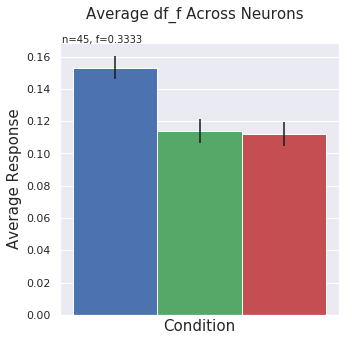

In [106]:
#average over images
filter_response_cond_per_neuron = np.zeros((3,nrois))
for ridx in range(nrois):
#ridx = 0 
    filtered_resp_tmp = np.array([])
    for cfg_idx in range(0,nconfigs,3):
        if filtered_resp_tmp.size ==0:
            filtered_resp_tmp = filt_response_array[cfg_idx:cfg_idx+3,ridx]
        else:
            filtered_resp_tmp = np.vstack((filtered_resp_tmp ,filt_response_array[cfg_idx:cfg_idx+3,ridx]))

        filter_response_cond_per_neuron[:,ridx] = np.nanmean(filtered_resp_tmp,0)

filter_response_cond_mean_neuron = np.nanmean(filter_response_cond_per_neuron,1)
filter_response_cond_se_neuron = np.nanstd(filter_response_cond_per_neuron,1)/np.sqrt(num_active_rois)

cond_labels = ['Original','Sf-Match','Corr-Match']

bar_loc = np.zeros((3,))
width = 0.4         # the width of the bars
xloc = 1
count = 0

for j in range(len(np.unique(trial_cond))):
    bar_loc[count] = xloc
    xloc = xloc + width
    count = count+1

fig = plt.figure(figsize=(5,5))
plt.bar(bar_loc[0],filter_response_cond_mean_neuron[0],width,color = 'b', alpha = 1, yerr = filter_response_cond_se_neuron[0])
plt.bar(bar_loc[1],filter_response_cond_mean_neuron[1],width,color = 'g', alpha = 1, yerr = filter_response_cond_se_neuron[1])
plt.bar(bar_loc[2],filter_response_cond_mean_neuron[2],width,color = 'r', alpha = 1, yerr = filter_response_cond_se_neuron[2])


axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')

xtick_loc = []
xtick_label = []

plt.xticks(xtick_loc,xtick_label)
plt.xlabel('Condition',fontsize = 15)
plt.ylabel('Average Response',fontsize = 15)
plt.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)


plt.text(bar_loc[0]-.25, ymax, 'n=%i, f=%.04f' % (num_active_rois, frac_active_rois), fontsize=10)

# blue_patch = patches.Patch(color='blue', label=cond_labels[0])
# green_patch = patches.Patch(color='green', label=cond_labels[1])
# red_patch = patches.Patch(color='red', label=cond_labels[2])

# plt.legend(bbox_to_anchor=(0, -0.3), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=8)

fig_fn = 'avg_response_per_cond_across_neurons_%s_thresh_%s_%i.png'%(response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(responses_dir,'figures',fig_fn)

fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)


In [141]:
sns.catplot

<function seaborn.categorical.catplot(x=None, y=None, hue=None, data=None, row=None, col=None, col_wrap=None, estimator=<function mean at 0x7ffb3005c8c8>, ci=95, n_boot=1000, units=None, order=None, hue_order=None, row_order=None, col_order=None, kind='strip', height=5, aspect=1, orient=None, color=None, palette=None, legend=True, legend_out=True, sharex=True, sharey=True, margin_titles=False, facet_kws=None, **kwargs)>

In [110]:
num_active_rois

45

In [111]:
active_cell_idx

array([ True, False, False, False,  True,  True, False, False, False,
       False, False,  True, False, False, False,  True,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False,  True, False,  True,  True,
        True, False, False, False, False, False, False,  True, False,
       False,  True, False,  True, False,  True,  True,  True, False,
        True, False, False, False, False,  True,  True, False, False,
       False, False,  True,  True, False, False,  True, False, False,
        True,  True, False, False, False,  True, False,  True, False,
        True, False, False, False,  True, False, False,  True, False,
       False, False,  True,  True,  True, False, False,  True,  True,
       False, False,  True,  True, False, False, False, False, False,
       False, False,  True, False,  True,  True, False,  True, False,
       False, False,

In [115]:
ylabel = 'Average Response'

resp_dfs = []
for cidx in range(filter_response_cond_per_neuron.shape[0]):
    response = filter_response_cond_per_neuron[cidx,active_cell_idx]
    cell = np.arange(num_active_rois)
    cond = np.ones((num_active_rois,))*cidx
    mdf = pd.DataFrame({'%s' % ylabel: response,
                        'response': response,
                        'cell': cell,
                        'cond': cond,
                       })

    resp_dfs.append(mdf)
resp_dfs = pd.concat(resp_dfs, axis=0)

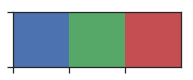

/home/cesar/envs/suite2p/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


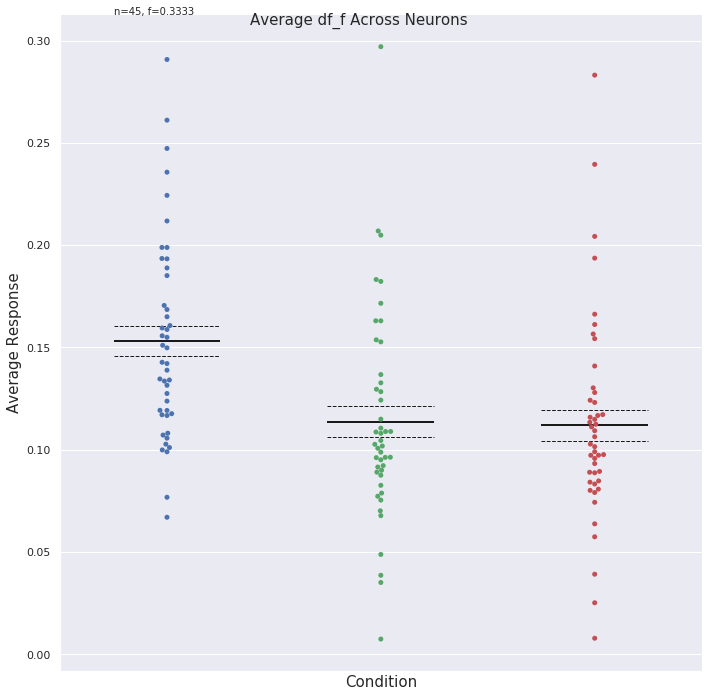

In [140]:
bar_loc = np.arange(0,3)
width = 0.5

sns.set_style("darkgrid")
palette = sns.color_palette(["#4c72b0","#55a868","#c44e52"])
sns.set_palette(palette)

p = sns.catplot(x='cond', y='response', kind="swarm", hue = 'cond',data=resp_dfs,size = 10);

axes = p.ax
ymin,ymax = axes.get_ylim()
xmin,xmax = axes.get_xlim()

for idx in range(len(np.unique(trial_cond))):
    p.ax.hlines(y = filter_response_cond_mean_neuron[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=2, color='k',linestyle = '-')
    p.ax.hlines(y = filter_response_cond_mean_neuron[idx] + filter_response_cond_se_neuron[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')
    p.ax.hlines(y = filter_response_cond_mean_neuron[idx] - filter_response_cond_se_neuron[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')




p.ax.set_xticks(())
p.ax.set_xlabel('Condition',fontsize = 15)
p.ax.set_ylabel('Average Response',fontsize = 15)
p.fig.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)


p.ax.text(bar_loc[0]-.25, ymax, 'n=%i, f=%.04f' % (num_active_rois, frac_active_rois), fontsize=10)


fig_fn = 'avg_response_per_cond_scatter_neurons_%s_thresh_%s_%i.png'%(response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(responses_dir,'figures',fig_fn)

fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)


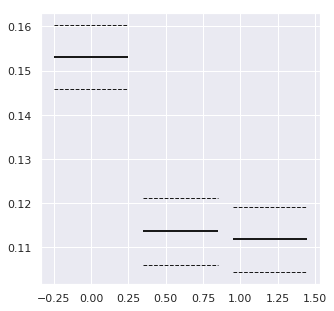

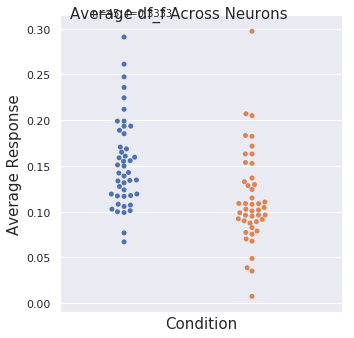

In [118]:
bar_loc = np.zeros((3,))
width = 0.5        # the width of the bars
xloc = 0
count = 0
gap = 0.1
for j in range(len(np.unique(trial_cond))):
    bar_loc[count] = xloc
    xloc = xloc + width+gap
    count = count+1

fig = plt.figure(figsize=(5,5))

p sns.catplot(x='cond', y='response', kind="swarm", data=resp_dfs,size = 10);

#plt.bar(bar_loc[0],filter_response_cond_mean_neuron[0],width,color = 'b', alpha = 0.5, yerr = filter_response_cond_se_neuron[0])
#plt.bar(bar_loc[1],filter_response_cond_mean_neuron[1],width,color = 'g', alpha = 0.5, yerr = filter_response_cond_se_neuron[1])
#plt.bar(bar_loc[2],filter_response_cond_mean_neuron[2],width,color = 'r', alpha = 0.5, yerr = filter_response_cond_se_neuron[2])

for idx in range(len(np.unique(trial_cond))):
    plt.hlines(y = filter_response_cond_mean_neuron[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=2, color='k',linestyle = '-')
    plt.hlines(y = filter_response_cond_mean_neuron[idx] + filter_response_cond_se_neuron[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')
    plt.hlines(y = filter_response_cond_mean_neuron[idx] - filter_response_cond_se_neuron[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')

# plt.scatter(bar_loc[0]*np.ones((num_active_rois,)),filter_response_cond_per_neuron[0,active_cell_idx],color = 'b')
# plt.scatter(bar_loc[1]*np.ones((num_active_rois,)),filter_response_cond_per_neuron[1,active_cell_idx],color = 'g')
# plt.scatter(bar_loc[2]*np.ones((num_active_rois,)),filter_response_cond_per_neuron[2,active_cell_idx],color = 'r')

axes = plt.gca()
axes.set_xlim([bar_loc[0]-width,bar_loc[-1]+width])
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()

xtick_loc = []
xtick_label = []

plt.xticks(xtick_loc,xtick_label)
plt.xlabel('Condition',fontsize = 15)
plt.ylabel('Average Response',fontsize = 15)
plt.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)


plt.text(bar_loc[0]-.25, ymax, 'n=%i, f=%.04f' % (num_active_rois, frac_active_rois), fontsize=10)

# blue_patch = patches.Patch(color='blue', label=cond_labels[0])
# green_patch = patches.Patch(color='green', label=cond_labels[1])
# red_patch = patches.Patch(color='red', label=cond_labels[2])

# plt.legend(bbox_to_anchor=(0, -0.3), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=8)

fig_fn = 'avg_response_per_cond_scatter_neurons_%s_thresh_%s_%i.png'%(response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(responses_dir,'figures',fig_fn)

fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)


In [108]:
#save arrays to file
# Create outfile:
data_array_fn = 'filtered_%s_responses_thresh_%s_%i.hdf5'%(response_type,filter_crit, filter_thresh)
data_array_filepath = os.path.join(data_array_dir, data_array_fn)
data_grp = h5py.File(data_array_filepath, 'w')

data_grp.attrs['s2p_cell_rois'] = cell_rois

data_grp.attrs['nconfigs'] = nconfigs
data_grp.attrs['nrois'] = nrois

img_dset = data_grp.create_dataset('config_img', config_img.shape, config_img.dtype)
img_dset[...] = config_img

cond_dset = data_grp.create_dataset('config_cond',config_img.shape, config_img.dtype)
cond_dset[...] = config_cond

nrois_dset = data_grp.create_dataset('/'.join([curr_slice, 'n_active_rois' ]), num_active_rois.shape, num_active_rois.dtype)
nrois_dset[...] = num_active_rois

frois_dset = data_grp.create_dataset('/'.join([curr_slice, 'frac_active_rois' ]), frac_active_rois.shape, frac_active_rois.dtype)
frois_dset[...] = frac_active_rois

act_idx_dset = data_grp.create_dataset('/'.join([curr_slice, 'active_cell_idx' ]), active_cell_idx.shape, active_cell_idx.dtype)
act_idx_dset[...] = active_cell_idx

passrois_dset = data_grp.create_dataset('/'.join([curr_slice, 'active_rois_per_config' ]), active_rois_per_config.shape, active_rois_per_config.dtype)
passrois_dset[...] = active_rois_per_config


filt_trace_cfg_neu_dset = data_grp.create_dataset('/'.join([curr_slice, 'filtered_response_per_cond_per_neuron' ]), filt_response_array.shape, filt_response_array.dtype)
filt_trace_cfg_neu_dset[...] = filt_response_array

filt_trace_cond_mean_neu_dset = data_grp.create_dataset('/'.join([curr_slice, 'filtered_response_per_cond_mean_across_neurons' ]), filter_response_cond_mean_neuron.shape, filter_response_cond_mean_neuron.dtype)
filt_trace_cond_mean_neu_dset[...] = filter_response_cond_mean_neuron

filt_trace_cond_se_neu_dset = data_grp.create_dataset('/'.join([curr_slice, 'filtered_response_per_cond_se_across_neurons' ]), filter_response_cond_se_neuron.shape, filter_response_cond_se_neuron.dtype)
filt_trace_cond_se_neu_dset[...] = filter_response_cond_se_neuron

filt_trace_cfg_mean_neu_dset = data_grp.create_dataset('/'.join([curr_slice, 'filtered_response_per_cfg_mean_across_neurons' ]), img_response_mean.shape, img_response_mean.dtype)
filt_trace_cfg_mean_neu_dset[...] = img_response_mean

filt_trace_cfg_se_neu_dset = data_grp.create_dataset('/'.join([curr_slice, 'filtered_response_per_cfg_se_across_neurons' ]), img_response_se.shape, img_response_se.dtype)
filt_trace_cfg_se_neu_dset[...] = img_response_se

midx_dset = data_grp.create_dataset('/'.join([curr_slice, 'mod_idx_mean_across_neurons' ]), mean_mod_idx.shape, mean_mod_idx.dtype)
midx_dset[...] = mean_mod_idx

mdif_dset = data_grp.create_dataset('/'.join([curr_slice, 'diff_mean_across_neurons' ]), mean_diff.shape, mean_diff.dtype)
mdif_dset[...] = mean_diff


data_grp.close()